# Notebook2: Predicting CO2 emissions using Neural Networks

Readme: In this notebook, NN models are constructed for CO2 Emission prediction, and the best model is selected and K-means validation is applied.

- **Notebook content**:
    - Design the architecture of NN and explore different model configuration

    - Tune hyperparameters and select the best model

- **Notebook Output**:

    - Best model file

    - The validation and test results of the best model

In [21]:
# %pip install "numpy<2" torch torchvision scikit-learn
# %pip install wandb

In [22]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## 1 Define Functions

In [23]:
# Define functions
import seaborn as sns
import torch

# 1 plot related functions----------------
# plot predict and true values on validation dataset
def plot_pred_true(y_test, y_pred, ax):

    data = pd.DataFrame({'y_obs': y_test, 'y_pred': y_pred})

    # plt.figure(figsize=(5, 5))
    sns.scatterplot(data=data, x='y_obs', y='y_pred', s=10, ax=ax)
    ax.plot(y_test, y_test, color='red', label='y=x')          # plot the line y=x
    ax.set_title('Observed vs Predicted values in Test Dataset')   # title
    ax.set_xlabel('Observed values')       # label for the x-axis
    ax.set_ylabel('Predicted values')      # label for the y-axis
    ax.legend()
    ax.grid(True)

# plot the loss value on training and validation dataset
def plot_train_val_loss(train_loss, val_loss, ax):
    
    # ax.figure(figsize=(5, 5))

    ax.plot(train_loss, label='train loss')
    ax.plot(val_loss, label='val loss')
    ax.set_title('Train vs Validation Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(True)

# 2 Other functions---------------------
# get the prediction and true values
def model_prediction(model, val_loader, device):

    model.eval()
    pred = []
    target = []

    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)

            y_pred = model(X)      # predicted value

            pred.extend(y_pred.cpu().numpy())
            target.extend(y.cpu().numpy())

    # Merge all the predictions and targets
    predictions = np.concatenate(pred, axis=0)
    labels = np.concatenate(target, axis=0)
    return predictions, labels

## 2 Data Preparation

In [24]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

### Load and Divide Traning and Testing Data

Load the test and train dataset

In [25]:
# Import data
trainset_df = pd.read_csv('Dataset2_train.csv').dropna()
testset_df = pd.read_csv('Dataset2_test.csv').dropna()


In [26]:
trainset_df

,Engine Size(L),Cylinders,Gearbox_Type,Gearbox_Number,Energy Consumption per Distance MJ/100km,Model Features_Flexible-fuel vehicle,Model Features_Four-wheel drive,Model Features_Long wheelbase,Model Features_Short wheelbase,Vehicle Class_FULL-SIZE,...,Vehicle Class_SUV - SMALL,Vehicle Class_SUV - STANDARD,Vehicle Class_TWO-SEATER,Vehicle Class_VAN - CARGO,Vehicle Class_VAN - PASSENGER,Fuel Type_E,Fuel Type_X,Fuel Type_Z,CO2 Emissions(g/km),Make
0,4.0,6.0,1.0,5.000000,434.34,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,299.0,NISSAN
1,2.4,4.0,1.0,6.000000,287.28,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,193.0,HYUNDAI
2,2.0,4.0,1.0,8.000000,321.48,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,221.0,BMW
3,2.5,4.0,1.0,6.000000,307.80,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,212.0,TOYOTA
4,5.0,8.0,1.0,8.000000,454.86,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,313.0,JAGUAR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5902,2.0,4.0,1.0,6.000000,287.28,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,197.0,MINI
5903,5.6,8.0,1.0,7.000000,526.68,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,362.0,NISSAN
5904,3.5,6.0,1.0,6.000000,283.86,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,193.0,TOYOTA
5905,2.5,4.0,1.0,6.854093,294.12,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,198.0,NISSAN


In [27]:
X_train = trainset_df.drop(columns=['CO2 Emissions(g/km)', 'Make'])
y_train = trainset_df['CO2 Emissions(g/km)']

X_test = testset_df.drop(columns=['CO2 Emissions(g/km)', 'Make'])
y_test = testset_df['CO2 Emissions(g/km)']

In [28]:
X_train

,Engine Size(L),Cylinders,Gearbox_Type,Gearbox_Number,Energy Consumption per Distance MJ/100km,Model Features_Flexible-fuel vehicle,Model Features_Four-wheel drive,Model Features_Long wheelbase,Model Features_Short wheelbase,Vehicle Class_FULL-SIZE,...,Vehicle Class_STATION WAGON - SMALL,Vehicle Class_SUBCOMPACT,Vehicle Class_SUV - SMALL,Vehicle Class_SUV - STANDARD,Vehicle Class_TWO-SEATER,Vehicle Class_VAN - CARGO,Vehicle Class_VAN - PASSENGER,Fuel Type_E,Fuel Type_X,Fuel Type_Z
0,4.0,6.0,1.0,5.000000,434.34,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2.4,4.0,1.0,6.000000,287.28,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2.0,4.0,1.0,8.000000,321.48,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2.5,4.0,1.0,6.000000,307.80,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,5.0,8.0,1.0,8.000000,454.86,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5902,2.0,4.0,1.0,6.000000,287.28,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5903,5.6,8.0,1.0,7.000000,526.68,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
5904,3.5,6.0,1.0,6.000000,283.86,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
5905,2.5,4.0,1.0,6.854093,294.12,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### Setup pipline for Standardisation

In [29]:
binary_columns = X_train.columns[X_train.nunique() == 2].tolist()  
numerical_columns = [col for col in X_train.columns if col not in binary_columns]

# ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns)  # StandardScale
    ], 
    remainder='passthrough'  # keep dummy variable
)

# Setup pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

In [30]:
X_train_processed = pipeline.fit_transform(X_train)
X_test_processed = pipeline.transform(X_test)

Inspect the processed data

In [31]:
feature_names = list(X_train) 
X_train_df = pd.DataFrame(X_train_processed, columns=feature_names)

X_test_df = pd.DataFrame(X_test_processed, columns=feature_names)

print("Processed Train Dataset：")
print(X_train_df.head())

print("Processed Test Dataset：")
print(X_test_df.head())


Processed Train Dataset：
   Engine Size(L)  Cylinders  Gearbox_Type  Gearbox_Number  \
0        0.612690   0.200638     -1.602571        0.771485   
1       -0.567895  -0.889172     -0.750938       -0.943120   
2       -0.863042  -0.889172      0.952329       -0.544375   
3       -0.494109  -0.889172     -0.750938       -0.703873   
4        1.350555   1.290448      0.952329        1.010732   

   Energy Consumption per Distance MJ/100km  \
0                                       1.0   
1                                       1.0   
2                                       1.0   
3                                       1.0   
4                                       1.0   

   Model Features_Flexible-fuel vehicle  Model Features_Four-wheel drive  \
0                                   0.0                              0.0   
1                                   0.0                              0.0   
2                                   0.0                              0.0   
3              

In [32]:
# Prepare the Dataloader
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Convert data to Tensor
X_train_tensor = torch.tensor(X_train_processed, dtype=torch.float32) 
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)

X_val_tensor = torch.tensor(X_test_processed, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Load the training data and validation data
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_val_tensor,y_test_tensor)

# Set hyperparameters
batch_size = 64  # batch size

# Create data loader
train_Loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_Loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)



## 3 Best Models

#### Pre: k-fold Import K-fold Cross-validation Method

In [33]:
from sklearn.model_selection import KFold

k_fold = KFold(n_splits=20, shuffle=True, random_state=42) # Set randon seed to make sure the results are reproducible

Import metrics

In [34]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

### 3.1 Neural Network Model

#### 3.1.1 Use W&B Grid Search to Find Best NN Parameter Set

In [35]:
import wandb

wandb.login(key="47ea61c7ee69e2e0e1cc46ed5c31bd6168f9f9db")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

Neural Network Structure

In [36]:
class MultiLayerPerceptron(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(MultiLayerPerceptron, self).__init__()

        # Initialise an empty list to hold layers
        layers = []

        # First layer: input to hidden
        layers.append(nn.Linear(input_size, hidden_size))
        layers.append(nn.ReLU())

        # Additional hidden layers
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())
            
        # Output layer: hidden to output
        layers.append(nn.Linear(hidden_size, output_size))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [37]:
from torch.utils.data import random_split

# Calculate the sizes for train and validation splits
num_total = len(train_dataset)
num_train = int(0.9 * num_total)
num_val = num_total - num_train

# Split the dataset
train_subset, val_subset = random_split(train_dataset, [num_train, num_val])

# Create DataLoaders for each subset
train_Loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_Loader = DataLoader(val_subset, batch_size=64, shuffle=False)

In [38]:
# Hyperparameter grid
hidden_units_options = [32, 64, 128]    # Numbers of neurons in each hidden layer
hidden_layers_options = [2, 3, 4]       # Numbers of hidden layers
learning_rates = [0.1, 0.01, 0.001]     # Learning rates

max_epochs = 200  # Arbitrarily large; early stopping will likely stop earlier.
patience = 5      # Early stopping patience

input_size =  X_train_processed.shape[1]   # Input size 
output_size = 1             # Output size

learning_rate = 0.02        # Learning rate
n_epochs = 100 # Numebr of epochs

# Define the loss function and the optimizer
criterion = nn.MSELoss()    # Mean Squared Error for Linear Regression


In [39]:
# Define helper functions
# Train epoch function
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0

    # for features, target in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
    for features, target in train_loader:
        features, target = features.to(device), target.to(device)

        optimizer.zero_grad()
        outputs = model(features) # Forward pass
        loss = criterion(outputs, target)

        loss.backward()  # Backward pass
        optimizer.step() # Update the weights

        running_loss += loss.item() * features.size(0)

    return running_loss / len(train_loader.dataset)

# Validation epoch function
def val_epoch(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for features, target in val_loader:
            # print(featuresfeatures.size(0))
            features, target = features.to(device), target.to(device)
            # features = features.view(features.size(0), -1)

            outputs = model(features)
            loss = criterion(outputs, target)
            val_loss += loss.item() * features.size(0)

    return val_loss / len(val_loader.dataset)



In [40]:
from itertools import product
import torch.optim as optim

for hidden_units, hidden_layers, lr in product(hidden_units_options, hidden_layers_options, learning_rates):

    # Configurations
    config = {
        "hidden_units": hidden_units,
        "hidden_layers": hidden_layers,
        "learning_rate": lr,
        "max_epochs": max_epochs,
        "patience": patience
    }

    # Start a new W&B run for each configuration
    wandb.init(project='DE_Groupwork_G4_stage2', config=config, reinit=True)

    model = MultiLayerPerceptron(input_size=input_size, 
                             hidden_size=config["hidden_units"], 
                             num_layers=config["hidden_layers"], 
                             output_size=1).to(device)


    criterion = nn.MSELoss() 
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_test_loss = float('inf')
    epochs_without_improvement = 0
        
    for epoch in range(1, max_epochs + 1):
        train_loss = train_epoch(model, train_Loader, criterion, optimizer, device)
       
        test_loss = val_epoch(model, test_Loader, criterion, device)

        # Log metrics to W&B
        wandb.log({"epoch": epoch, "train_loss": train_loss, "val_loss": test_loss})
        
        print(f"Epoch {epoch:03d} | Train Loss: {train_loss:.4f} | Val Loss: {test_loss:.4f}")
        
        # Early stopping check
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            
        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered at epoch {epoch}")
            break

    wandb.finish()

print("Training complete for all configurations.")


epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▂▂▂▂▁▁▁▁▁▁▁▁▁▁
epoch,16
train_loss,12.29559
val_loss,14.96132


Epoch 001 | Train Loss: 5055.8113 | Val Loss: 386.5393
Epoch 002 | Train Loss: 200.6517 | Val Loss: 275.0912
Epoch 003 | Train Loss: 137.1461 | Val Loss: 78.3422
Epoch 004 | Train Loss: 48.3149 | Val Loss: 42.4066
Epoch 005 | Train Loss: 25.8812 | Val Loss: 22.2532
Epoch 006 | Train Loss: 17.4433 | Val Loss: 24.2385
Epoch 007 | Train Loss: 17.7920 | Val Loss: 28.1264
Epoch 008 | Train Loss: 21.3657 | Val Loss: 16.2238
Epoch 009 | Train Loss: 19.8021 | Val Loss: 13.7176
Epoch 010 | Train Loss: 41.8537 | Val Loss: 24.6258
Epoch 011 | Train Loss: 33.2945 | Val Loss: 17.4210
Epoch 012 | Train Loss: 25.4260 | Val Loss: 40.5830
Epoch 013 | Train Loss: 20.3944 | Val Loss: 29.6083
Epoch 014 | Train Loss: 16.8619 | Val Loss: 27.4245
Early stopping triggered at epoch 14


epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▂▂▁▁▁▁▁▁▁▂▁▁
epoch,14
train_loss,16.86189
val_loss,27.42452


Epoch 001 | Train Loss: 24931.2334 | Val Loss: 1172.4511
Epoch 002 | Train Loss: 774.2374 | Val Loss: 602.1252
Epoch 003 | Train Loss: 471.1455 | Val Loss: 427.7222
Epoch 004 | Train Loss: 326.8845 | Val Loss: 312.3690
Epoch 005 | Train Loss: 243.7172 | Val Loss: 236.6762
Epoch 006 | Train Loss: 188.0148 | Val Loss: 189.4634
Epoch 007 | Train Loss: 157.3184 | Val Loss: 152.0116
Epoch 008 | Train Loss: 119.3719 | Val Loss: 121.8517
Epoch 009 | Train Loss: 97.4712 | Val Loss: 98.4290
Epoch 010 | Train Loss: 72.9526 | Val Loss: 77.0494
Epoch 011 | Train Loss: 55.7185 | Val Loss: 57.2192
Epoch 012 | Train Loss: 41.5780 | Val Loss: 41.6517
Epoch 013 | Train Loss: 29.3068 | Val Loss: 29.3581
Epoch 014 | Train Loss: 21.8768 | Val Loss: 21.2008
Epoch 015 | Train Loss: 16.8403 | Val Loss: 15.9695
Epoch 016 | Train Loss: 13.8282 | Val Loss: 13.9426
Epoch 017 | Train Loss: 12.0578 | Val Loss: 12.8645
Epoch 018 | Train Loss: 10.8648 | Val Loss: 10.5243
Epoch 019 | Train Loss: 10.3256 | Val Loss: 1

epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,32
train_loss,10.04514
val_loss,12.99181


Epoch 001 | Train Loss: 65733.8740 | Val Loss: 62547.0431
Epoch 002 | Train Loss: 54868.6784 | Val Loss: 40163.0229
Epoch 003 | Train Loss: 22379.5253 | Val Loss: 7416.2575
Epoch 004 | Train Loss: 3092.0431 | Val Loss: 1674.6059
Epoch 005 | Train Loss: 1426.6955 | Val Loss: 1359.6101
Epoch 006 | Train Loss: 1209.4802 | Val Loss: 1180.1064
Epoch 007 | Train Loss: 1061.6001 | Val Loss: 1052.1785
Epoch 008 | Train Loss: 953.9952 | Val Loss: 955.6991
Epoch 009 | Train Loss: 869.2766 | Val Loss: 872.6750
Epoch 010 | Train Loss: 798.9139 | Val Loss: 808.8172
Epoch 011 | Train Loss: 740.0178 | Val Loss: 751.0069
Epoch 012 | Train Loss: 686.8102 | Val Loss: 700.4809
Epoch 013 | Train Loss: 641.6717 | Val Loss: 657.3572
Epoch 014 | Train Loss: 601.0944 | Val Loss: 616.1982
Epoch 015 | Train Loss: 563.8349 | Val Loss: 582.8534
Epoch 016 | Train Loss: 529.2181 | Val Loss: 548.2846
Epoch 017 | Train Loss: 497.1217 | Val Loss: 517.1481
Epoch 018 | Train Loss: 467.3126 | Val Loss: 487.8445
Epoch 019

epoch,▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
train_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,103
train_loss,8.50718
val_loss,11.34755


Epoch 001 | Train Loss: 7119.5260 | Val Loss: 417.4285
Epoch 002 | Train Loss: 235.8946 | Val Loss: 173.2436
Epoch 003 | Train Loss: 123.0375 | Val Loss: 113.9063
Epoch 004 | Train Loss: 61.7953 | Val Loss: 42.3670
Epoch 005 | Train Loss: 23.2302 | Val Loss: 48.1002
Epoch 006 | Train Loss: 25.8073 | Val Loss: 25.8114
Epoch 007 | Train Loss: 18.1508 | Val Loss: 26.9431
Epoch 008 | Train Loss: 17.0112 | Val Loss: 78.2741
Epoch 009 | Train Loss: 29.4616 | Val Loss: 15.2682
Epoch 010 | Train Loss: 16.1405 | Val Loss: 16.9459
Epoch 011 | Train Loss: 14.5878 | Val Loss: 17.1351
Epoch 012 | Train Loss: 13.4734 | Val Loss: 12.3853
Epoch 013 | Train Loss: 17.7075 | Val Loss: 15.8130
Epoch 014 | Train Loss: 17.9688 | Val Loss: 68.5004
Epoch 015 | Train Loss: 57.8691 | Val Loss: 62.7928
Epoch 016 | Train Loss: 47.5255 | Val Loss: 21.7047
Epoch 017 | Train Loss: 25.2442 | Val Loss: 11.8696
Epoch 018 | Train Loss: 24.1563 | Val Loss: 26.2393
Epoch 019 | Train Loss: 27.2092 | Val Loss: 28.2508
Epoch

epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▂▂▁▁▂▁▁▁▁▁▂▂▁▁▁▁▆▆▄
epoch,22
train_loss,151.04667
val_loss,210.78354


Epoch 001 | Train Loss: 17719.3351 | Val Loss: 712.4350
Epoch 002 | Train Loss: 487.0564 | Val Loss: 357.8131
Epoch 003 | Train Loss: 251.8133 | Val Loss: 211.0036
Epoch 004 | Train Loss: 156.3632 | Val Loss: 150.4339
Epoch 005 | Train Loss: 112.6192 | Val Loss: 109.9858
Epoch 006 | Train Loss: 81.4521 | Val Loss: 81.2172
Epoch 007 | Train Loss: 56.0465 | Val Loss: 53.8496
Epoch 008 | Train Loss: 37.3309 | Val Loss: 33.7464
Epoch 009 | Train Loss: 23.9426 | Val Loss: 29.8294
Epoch 010 | Train Loss: 18.0410 | Val Loss: 19.9640
Epoch 011 | Train Loss: 14.1497 | Val Loss: 15.4362
Epoch 012 | Train Loss: 12.0386 | Val Loss: 12.7167
Epoch 013 | Train Loss: 11.2725 | Val Loss: 12.9143
Epoch 014 | Train Loss: 10.8886 | Val Loss: 15.0969
Epoch 015 | Train Loss: 10.5975 | Val Loss: 11.3786
Epoch 016 | Train Loss: 11.3155 | Val Loss: 20.9626
Epoch 017 | Train Loss: 10.6903 | Val Loss: 10.6017
Epoch 018 | Train Loss: 10.2490 | Val Loss: 10.4427
Epoch 019 | Train Loss: 9.6404 | Val Loss: 11.3996
E

epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,23
train_loss,12.31108
val_loss,14.65916


Epoch 001 | Train Loss: 65231.6942 | Val Loss: 58768.6640
Epoch 002 | Train Loss: 27785.1750 | Val Loss: 2063.2405
Epoch 003 | Train Loss: 1459.9863 | Val Loss: 1164.1234
Epoch 004 | Train Loss: 964.5123 | Val Loss: 862.0985
Epoch 005 | Train Loss: 738.7879 | Val Loss: 689.5504
Epoch 006 | Train Loss: 596.3224 | Val Loss: 574.2004
Epoch 007 | Train Loss: 494.6044 | Val Loss: 484.3730
Epoch 008 | Train Loss: 415.3601 | Val Loss: 417.6790
Epoch 009 | Train Loss: 355.3172 | Val Loss: 363.8477
Epoch 010 | Train Loss: 307.6970 | Val Loss: 319.8005
Epoch 011 | Train Loss: 268.7548 | Val Loss: 283.3686
Epoch 012 | Train Loss: 234.9372 | Val Loss: 251.3078
Epoch 013 | Train Loss: 207.1117 | Val Loss: 222.5125
Epoch 014 | Train Loss: 183.4014 | Val Loss: 197.3305
Epoch 015 | Train Loss: 162.3411 | Val Loss: 177.2830
Epoch 016 | Train Loss: 144.9132 | Val Loss: 160.3344
Epoch 017 | Train Loss: 129.8469 | Val Loss: 143.6151
Epoch 018 | Train Loss: 117.1514 | Val Loss: 131.0189
Epoch 019 | Train L

epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇████
train_loss,█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,65
train_loss,9.43984
val_loss,10.70175


Epoch 001 | Train Loss: 34402.1500 | Val Loss: 716.0630
Epoch 002 | Train Loss: 383.8350 | Val Loss: 236.7410
Epoch 003 | Train Loss: 164.9004 | Val Loss: 123.6946
Epoch 004 | Train Loss: 89.3654 | Val Loss: 83.5468
Epoch 005 | Train Loss: 51.5380 | Val Loss: 48.9792
Epoch 006 | Train Loss: 32.5599 | Val Loss: 38.3793
Epoch 007 | Train Loss: 20.1547 | Val Loss: 25.4308
Epoch 008 | Train Loss: 15.6033 | Val Loss: 16.4398
Epoch 009 | Train Loss: 13.2780 | Val Loss: 28.6706
Epoch 010 | Train Loss: 16.0886 | Val Loss: 19.2295
Epoch 011 | Train Loss: 14.7379 | Val Loss: 30.8485
Epoch 012 | Train Loss: 18.7615 | Val Loss: 15.2894
Epoch 013 | Train Loss: 20.4410 | Val Loss: 14.8297
Epoch 014 | Train Loss: 19.4715 | Val Loss: 18.1287
Epoch 015 | Train Loss: 15.8324 | Val Loss: 12.1730
Epoch 016 | Train Loss: 14.0049 | Val Loss: 23.9789
Epoch 017 | Train Loss: 20.5387 | Val Loss: 12.6254
Epoch 018 | Train Loss: 18.2814 | Val Loss: 27.3085
Epoch 019 | Train Loss: 21.1429 | Val Loss: 33.4007
Epoc

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,20
train_loss,18.12516
val_loss,28.52265


Epoch 001 | Train Loss: 18425.2933 | Val Loss: 656.4210
Epoch 002 | Train Loss: 447.3147 | Val Loss: 339.9489
Epoch 003 | Train Loss: 243.9274 | Val Loss: 230.2027
Epoch 004 | Train Loss: 155.7539 | Val Loss: 144.6338
Epoch 005 | Train Loss: 107.9560 | Val Loss: 105.4958
Epoch 006 | Train Loss: 74.3123 | Val Loss: 73.5580
Epoch 007 | Train Loss: 50.3399 | Val Loss: 51.5699
Epoch 008 | Train Loss: 33.9790 | Val Loss: 33.5522
Epoch 009 | Train Loss: 23.0308 | Val Loss: 21.7258
Epoch 010 | Train Loss: 16.9516 | Val Loss: 22.1394
Epoch 011 | Train Loss: 14.9112 | Val Loss: 21.3439
Epoch 012 | Train Loss: 11.9098 | Val Loss: 12.2906
Epoch 013 | Train Loss: 11.7025 | Val Loss: 12.2591
Epoch 014 | Train Loss: 11.1908 | Val Loss: 14.0468
Epoch 015 | Train Loss: 11.4210 | Val Loss: 16.3723
Epoch 016 | Train Loss: 10.4262 | Val Loss: 12.0791
Epoch 017 | Train Loss: 11.8794 | Val Loss: 13.6807
Epoch 018 | Train Loss: 12.5971 | Val Loss: 11.5939
Epoch 019 | Train Loss: 11.5684 | Val Loss: 16.2070


epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,23
train_loss,12.6913
val_loss,16.30709


Epoch 001 | Train Loss: 65203.3231 | Val Loss: 56742.6669
Epoch 002 | Train Loss: 18333.8864 | Val Loss: 1523.1928
Epoch 003 | Train Loss: 1167.6989 | Val Loss: 961.2563
Epoch 004 | Train Loss: 822.0555 | Val Loss: 741.4378
Epoch 005 | Train Loss: 644.2046 | Val Loss: 597.2482
Epoch 006 | Train Loss: 518.0986 | Val Loss: 487.9431
Epoch 007 | Train Loss: 416.1298 | Val Loss: 392.1705
Epoch 008 | Train Loss: 332.3929 | Val Loss: 317.4909
Epoch 009 | Train Loss: 264.4756 | Val Loss: 254.5036
Epoch 010 | Train Loss: 208.9390 | Val Loss: 203.2331
Epoch 011 | Train Loss: 163.9568 | Val Loss: 160.2926
Epoch 012 | Train Loss: 127.2191 | Val Loss: 124.7645
Epoch 013 | Train Loss: 98.4318 | Val Loss: 96.8438
Epoch 014 | Train Loss: 76.7434 | Val Loss: 74.8067
Epoch 015 | Train Loss: 59.2959 | Val Loss: 58.1473
Epoch 016 | Train Loss: 46.3460 | Val Loss: 46.0010
Epoch 017 | Train Loss: 37.2068 | Val Loss: 35.9481
Epoch 018 | Train Loss: 30.5744 | Val Loss: 29.8531
Epoch 019 | Train Loss: 25.5500 

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,48
train_loss,9.27894
val_loss,9.88903


Epoch 001 | Train Loss: 5192.7608 | Val Loss: 325.5123
Epoch 002 | Train Loss: 192.7259 | Val Loss: 149.1354
Epoch 003 | Train Loss: 92.8710 | Val Loss: 69.9078
Epoch 004 | Train Loss: 43.8333 | Val Loss: 47.2958
Epoch 005 | Train Loss: 30.7476 | Val Loss: 107.8213
Epoch 006 | Train Loss: 32.1876 | Val Loss: 24.6366
Epoch 007 | Train Loss: 26.5800 | Val Loss: 55.1358
Epoch 008 | Train Loss: 22.5953 | Val Loss: 26.0101
Epoch 009 | Train Loss: 19.9011 | Val Loss: 27.9519
Epoch 010 | Train Loss: 17.3596 | Val Loss: 50.1066
Epoch 011 | Train Loss: 27.2065 | Val Loss: 63.6248
Early stopping triggered at epoch 11


epoch,▁▂▂▃▄▅▅▆▇▇█
train_loss,█▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▂▂▃▁▂▁▁▂▂
epoch,11
train_loss,27.2065
val_loss,63.62482


Epoch 001 | Train Loss: 17267.5050 | Val Loss: 853.7421
Epoch 002 | Train Loss: 598.5725 | Val Loss: 470.9383
Epoch 003 | Train Loss: 346.9023 | Val Loss: 316.6872
Epoch 004 | Train Loss: 236.2614 | Val Loss: 239.5356
Epoch 005 | Train Loss: 175.1976 | Val Loss: 177.5332
Epoch 006 | Train Loss: 133.5725 | Val Loss: 131.2349
Epoch 007 | Train Loss: 98.0976 | Val Loss: 99.6767
Epoch 008 | Train Loss: 73.7931 | Val Loss: 72.3106
Epoch 009 | Train Loss: 49.9802 | Val Loss: 48.5849
Epoch 010 | Train Loss: 33.6392 | Val Loss: 36.5197
Epoch 011 | Train Loss: 25.5804 | Val Loss: 23.3409
Epoch 012 | Train Loss: 15.9914 | Val Loss: 16.9143
Epoch 013 | Train Loss: 13.9305 | Val Loss: 13.0729
Epoch 014 | Train Loss: 11.9211 | Val Loss: 12.3880
Epoch 015 | Train Loss: 10.8790 | Val Loss: 11.7529
Epoch 016 | Train Loss: 11.1471 | Val Loss: 11.9434
Epoch 017 | Train Loss: 11.5553 | Val Loss: 11.0973
Epoch 018 | Train Loss: 10.0786 | Val Loss: 13.1822
Epoch 019 | Train Loss: 10.3309 | Val Loss: 9.3423

epoch,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,24
train_loss,10.96041
val_loss,9.45906


Epoch 001 | Train Loss: 64363.3128 | Val Loss: 56244.5298
Epoch 002 | Train Loss: 33225.1612 | Val Loss: 6749.3744
Epoch 003 | Train Loss: 2359.2423 | Val Loss: 1511.9103
Epoch 004 | Train Loss: 1280.4664 | Val Loss: 1160.2959
Epoch 005 | Train Loss: 1017.0258 | Val Loss: 965.6258
Epoch 006 | Train Loss: 858.7559 | Val Loss: 836.3517
Epoch 007 | Train Loss: 748.9902 | Val Loss: 744.9218
Epoch 008 | Train Loss: 668.4721 | Val Loss: 673.7486
Epoch 009 | Train Loss: 604.5202 | Val Loss: 614.4564
Epoch 010 | Train Loss: 549.4909 | Val Loss: 566.6127
Epoch 011 | Train Loss: 502.9561 | Val Loss: 518.3803
Epoch 012 | Train Loss: 459.7191 | Val Loss: 479.2446
Epoch 013 | Train Loss: 423.8422 | Val Loss: 446.0505
Epoch 014 | Train Loss: 390.3716 | Val Loss: 412.4582
Epoch 015 | Train Loss: 360.6354 | Val Loss: 384.3488
Epoch 016 | Train Loss: 333.7512 | Val Loss: 359.1728
Epoch 017 | Train Loss: 309.7745 | Val Loss: 334.4535
Epoch 018 | Train Loss: 287.9351 | Val Loss: 313.4363
Epoch 019 | Trai

epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇███
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,89
train_loss,8.32714
val_loss,9.63614


Epoch 001 | Train Loss: 18143.0985 | Val Loss: 559.7778
Epoch 002 | Train Loss: 387.8014 | Val Loss: 248.3730
Epoch 003 | Train Loss: 195.8656 | Val Loss: 138.6152
Epoch 004 | Train Loss: 123.0777 | Val Loss: 289.4244
Epoch 005 | Train Loss: 82.0726 | Val Loss: 50.3887
Epoch 006 | Train Loss: 39.8121 | Val Loss: 33.3571
Epoch 007 | Train Loss: 25.7423 | Val Loss: 168.1718
Epoch 008 | Train Loss: 65.3236 | Val Loss: 147.5987
Epoch 009 | Train Loss: 25.6884 | Val Loss: 21.7529
Epoch 010 | Train Loss: 23.5091 | Val Loss: 22.3169
Epoch 011 | Train Loss: 24.4746 | Val Loss: 39.9728
Epoch 012 | Train Loss: 33.6162 | Val Loss: 18.6304
Epoch 013 | Train Loss: 22.8792 | Val Loss: 32.9800
Epoch 014 | Train Loss: 24.2412 | Val Loss: 16.2929
Epoch 015 | Train Loss: 14.9426 | Val Loss: 56.8622
Epoch 016 | Train Loss: 24.4686 | Val Loss: 24.7470
Epoch 017 | Train Loss: 21.2285 | Val Loss: 29.7211
Epoch 018 | Train Loss: 36.2715 | Val Loss: 60.3235
Epoch 019 | Train Loss: 35.5498 | Val Loss: 19.3244


epoch,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▅▁▁▃▃▁▁▁▁▁▁▂▁▁▂▁
epoch,19
train_loss,35.54976
val_loss,19.32442


Epoch 001 | Train Loss: 12160.6322 | Val Loss: 618.0973
Epoch 002 | Train Loss: 350.5433 | Val Loss: 277.4441
Epoch 003 | Train Loss: 200.0115 | Val Loss: 190.5541
Epoch 004 | Train Loss: 133.3197 | Val Loss: 164.0934
Epoch 005 | Train Loss: 101.3528 | Val Loss: 96.1793
Epoch 006 | Train Loss: 56.0141 | Val Loss: 42.3075
Epoch 007 | Train Loss: 28.0818 | Val Loss: 31.0421
Epoch 008 | Train Loss: 18.4821 | Val Loss: 28.3932
Epoch 009 | Train Loss: 15.2125 | Val Loss: 97.4634
Epoch 010 | Train Loss: 42.3612 | Val Loss: 16.9445
Epoch 011 | Train Loss: 16.4170 | Val Loss: 14.7418
Epoch 012 | Train Loss: 11.0059 | Val Loss: 16.8863
Epoch 013 | Train Loss: 11.3551 | Val Loss: 15.2503
Epoch 014 | Train Loss: 11.5349 | Val Loss: 12.0927
Epoch 015 | Train Loss: 10.3708 | Val Loss: 11.4736
Epoch 016 | Train Loss: 11.8706 | Val Loss: 13.0951
Epoch 017 | Train Loss: 10.4256 | Val Loss: 9.4590
Epoch 018 | Train Loss: 10.3924 | Val Loss: 18.0933
Epoch 019 | Train Loss: 10.9031 | Val Loss: 17.2166
Ep

epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁
epoch,22
train_loss,10.4996
val_loss,15.73323


Epoch 001 | Train Loss: 57986.0727 | Val Loss: 22766.7854
Epoch 002 | Train Loss: 4035.4942 | Val Loss: 1372.0008
Epoch 003 | Train Loss: 1094.7866 | Val Loss: 923.9417
Epoch 004 | Train Loss: 788.4923 | Val Loss: 725.7205
Epoch 005 | Train Loss: 625.1827 | Val Loss: 594.9498
Epoch 006 | Train Loss: 512.9911 | Val Loss: 499.0711
Epoch 007 | Train Loss: 418.0189 | Val Loss: 412.7262
Epoch 008 | Train Loss: 333.9242 | Val Loss: 335.1363
Epoch 009 | Train Loss: 270.3012 | Val Loss: 280.9656
Epoch 010 | Train Loss: 222.8646 | Val Loss: 237.1135
Epoch 011 | Train Loss: 188.6254 | Val Loss: 205.7430
Epoch 012 | Train Loss: 160.5706 | Val Loss: 178.1992
Epoch 013 | Train Loss: 139.1812 | Val Loss: 154.5165
Epoch 014 | Train Loss: 120.5366 | Val Loss: 135.2728
Epoch 015 | Train Loss: 104.7508 | Val Loss: 119.6250
Epoch 016 | Train Loss: 90.4864 | Val Loss: 101.7356
Epoch 017 | Train Loss: 77.8074 | Val Loss: 88.4327
Epoch 018 | Train Loss: 67.4834 | Val Loss: 75.4947
Epoch 019 | Train Loss: 56

epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,60
train_loss,8.82807
val_loss,11.84801


Epoch 001 | Train Loss: 18075.8533 | Val Loss: 344.3784
Epoch 002 | Train Loss: 209.3332 | Val Loss: 605.4572
Epoch 003 | Train Loss: 180.5714 | Val Loss: 80.3324
Epoch 004 | Train Loss: 63.6147 | Val Loss: 63.9507
Epoch 005 | Train Loss: 43.9654 | Val Loss: 40.9597
Epoch 006 | Train Loss: 36.5483 | Val Loss: 131.0935
Epoch 007 | Train Loss: 34.7883 | Val Loss: 33.4975
Epoch 008 | Train Loss: 31.3200 | Val Loss: 179.9674
Epoch 009 | Train Loss: 47.4981 | Val Loss: 19.0297
Epoch 010 | Train Loss: 20.1999 | Val Loss: 35.4473
Epoch 011 | Train Loss: 23.3882 | Val Loss: 26.5983
Epoch 012 | Train Loss: 31.1713 | Val Loss: 73.6796
Epoch 013 | Train Loss: 27.0597 | Val Loss: 44.3723
Epoch 014 | Train Loss: 18.5001 | Val Loss: 13.4115
Epoch 015 | Train Loss: 17.8245 | Val Loss: 17.1326
Epoch 016 | Train Loss: 28.7106 | Val Loss: 89.3151
Epoch 017 | Train Loss: 20.1786 | Val Loss: 30.4396
Epoch 018 | Train Loss: 20.1319 | Val Loss: 46.6641
Epoch 019 | Train Loss: 14.4211 | Val Loss: 173.5616
Ea

epoch,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅█▂▂▁▂▁▃▁▁▁▂▁▁▁▂▁▁▃
epoch,19
train_loss,14.42109
val_loss,173.56161


Epoch 001 | Train Loss: 10648.5813 | Val Loss: 525.1911
Epoch 002 | Train Loss: 307.4669 | Val Loss: 227.3155
Epoch 003 | Train Loss: 147.8186 | Val Loss: 128.0268
Epoch 004 | Train Loss: 92.0354 | Val Loss: 79.2228
Epoch 005 | Train Loss: 55.1117 | Val Loss: 57.2632
Epoch 006 | Train Loss: 33.6754 | Val Loss: 28.4021
Epoch 007 | Train Loss: 22.2331 | Val Loss: 17.9227
Epoch 008 | Train Loss: 15.4551 | Val Loss: 17.4065
Epoch 009 | Train Loss: 12.5036 | Val Loss: 14.3883
Epoch 010 | Train Loss: 13.0597 | Val Loss: 23.5141
Epoch 011 | Train Loss: 11.9029 | Val Loss: 26.6178
Epoch 012 | Train Loss: 12.5756 | Val Loss: 13.6984
Epoch 013 | Train Loss: 11.9874 | Val Loss: 14.0819
Epoch 014 | Train Loss: 11.8427 | Val Loss: 97.5833
Epoch 015 | Train Loss: 25.4574 | Val Loss: 18.0804
Epoch 016 | Train Loss: 13.2368 | Val Loss: 15.7732
Epoch 017 | Train Loss: 15.9741 | Val Loss: 12.7971
Epoch 018 | Train Loss: 14.2962 | Val Loss: 12.2794
Epoch 019 | Train Loss: 13.9305 | Val Loss: 18.9796
Epoc

epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
epoch,23
train_loss,15.00506
val_loss,22.94763


Epoch 001 | Train Loss: 46436.5950 | Val Loss: 3358.8484
Epoch 002 | Train Loss: 1653.8529 | Val Loss: 935.9056
Epoch 003 | Train Loss: 709.4347 | Val Loss: 568.5702
Epoch 004 | Train Loss: 460.1745 | Val Loss: 413.0083
Epoch 005 | Train Loss: 342.8965 | Val Loss: 326.5190
Epoch 006 | Train Loss: 270.9324 | Val Loss: 272.4373
Epoch 007 | Train Loss: 224.2182 | Val Loss: 226.0635
Epoch 008 | Train Loss: 188.0543 | Val Loss: 194.4197
Epoch 009 | Train Loss: 159.3062 | Val Loss: 168.4466
Epoch 010 | Train Loss: 136.8231 | Val Loss: 151.0519
Epoch 011 | Train Loss: 117.8964 | Val Loss: 127.1176
Epoch 012 | Train Loss: 101.9651 | Val Loss: 111.9395
Epoch 013 | Train Loss: 87.1872 | Val Loss: 93.9349
Epoch 014 | Train Loss: 74.3033 | Val Loss: 80.7467
Epoch 015 | Train Loss: 62.2128 | Val Loss: 68.9352
Epoch 016 | Train Loss: 51.9342 | Val Loss: 57.9646
Epoch 017 | Train Loss: 43.6343 | Val Loss: 48.8242
Epoch 018 | Train Loss: 35.4131 | Val Loss: 39.1452
Epoch 019 | Train Loss: 29.1309 | Va

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇██
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,53
train_loss,8.72316
val_loss,8.85857


Epoch 001 | Train Loss: 6161.3002 | Val Loss: 320.1049
Epoch 002 | Train Loss: 215.7855 | Val Loss: 147.4443
Epoch 003 | Train Loss: 85.1028 | Val Loss: 68.0766
Epoch 004 | Train Loss: 41.0391 | Val Loss: 56.3514
Epoch 005 | Train Loss: 33.5343 | Val Loss: 51.5550
Epoch 006 | Train Loss: 29.1334 | Val Loss: 63.2957
Epoch 007 | Train Loss: 29.8018 | Val Loss: 23.1977
Epoch 008 | Train Loss: 23.6108 | Val Loss: 27.1072
Epoch 009 | Train Loss: 22.1402 | Val Loss: 20.1813
Epoch 010 | Train Loss: 29.5044 | Val Loss: 27.9583
Epoch 011 | Train Loss: 28.7157 | Val Loss: 59.9397
Epoch 012 | Train Loss: 37.0203 | Val Loss: 92.4695
Epoch 013 | Train Loss: 27.5616 | Val Loss: 35.2073
Epoch 014 | Train Loss: 41.0202 | Val Loss: 79.1025
Early stopping triggered at epoch 14


epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▂▂▂▂▁▁▁▁▂▃▁▂
epoch,14
train_loss,41.02018
val_loss,79.10252


Epoch 001 | Train Loss: 11868.9105 | Val Loss: 623.9815
Epoch 002 | Train Loss: 404.0853 | Val Loss: 299.0077
Epoch 003 | Train Loss: 207.2255 | Val Loss: 180.0705
Epoch 004 | Train Loss: 129.4116 | Val Loss: 125.5208
Epoch 005 | Train Loss: 88.6137 | Val Loss: 80.8572
Epoch 006 | Train Loss: 58.5792 | Val Loss: 57.0443
Epoch 007 | Train Loss: 39.7577 | Val Loss: 39.4537
Epoch 008 | Train Loss: 27.2225 | Val Loss: 38.4197
Epoch 009 | Train Loss: 20.3879 | Val Loss: 17.8887
Epoch 010 | Train Loss: 14.6991 | Val Loss: 15.2264
Epoch 011 | Train Loss: 12.3468 | Val Loss: 14.4870
Epoch 012 | Train Loss: 12.8570 | Val Loss: 15.3507
Epoch 013 | Train Loss: 12.5139 | Val Loss: 14.4390
Epoch 014 | Train Loss: 12.7448 | Val Loss: 12.9599
Epoch 015 | Train Loss: 11.7140 | Val Loss: 11.3518
Epoch 016 | Train Loss: 10.8684 | Val Loss: 15.6472
Epoch 017 | Train Loss: 11.8571 | Val Loss: 10.6454
Epoch 018 | Train Loss: 10.3994 | Val Loss: 11.9221
Epoch 019 | Train Loss: 10.0599 | Val Loss: 17.1793
Ep

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,26
train_loss,11.47708
val_loss,12.52694


Epoch 001 | Train Loss: 60430.5116 | Val Loss: 40490.9460
Epoch 002 | Train Loss: 12502.3267 | Val Loss: 1787.1091
Epoch 003 | Train Loss: 1432.0483 | Val Loss: 1204.9077
Epoch 004 | Train Loss: 1019.3209 | Val Loss: 932.9828
Epoch 005 | Train Loss: 811.7232 | Val Loss: 768.4535
Epoch 006 | Train Loss: 677.8377 | Val Loss: 658.2248
Epoch 007 | Train Loss: 583.0443 | Val Loss: 580.0814
Epoch 008 | Train Loss: 509.5651 | Val Loss: 514.8161
Epoch 009 | Train Loss: 451.7313 | Val Loss: 463.1475
Epoch 010 | Train Loss: 403.4964 | Val Loss: 418.6938
Epoch 011 | Train Loss: 362.5015 | Val Loss: 381.4427
Epoch 012 | Train Loss: 328.0197 | Val Loss: 352.6426
Epoch 013 | Train Loss: 298.7592 | Val Loss: 325.3159
Epoch 014 | Train Loss: 273.3205 | Val Loss: 298.8444
Epoch 015 | Train Loss: 250.1828 | Val Loss: 276.1707
Epoch 016 | Train Loss: 230.1330 | Val Loss: 257.1826
Epoch 017 | Train Loss: 213.1308 | Val Loss: 238.6938
Epoch 018 | Train Loss: 196.7197 | Val Loss: 221.8047
Epoch 019 | Train 

epoch,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
train_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,72
train_loss,8.32913
val_loss,11.16157


Epoch 001 | Train Loss: 21007.4442 | Val Loss: 536.6022
Epoch 002 | Train Loss: 290.0784 | Val Loss: 284.0767
Epoch 003 | Train Loss: 152.1036 | Val Loss: 162.3482
Epoch 004 | Train Loss: 74.1049 | Val Loss: 173.3024
Epoch 005 | Train Loss: 48.4151 | Val Loss: 44.9480
Epoch 006 | Train Loss: 32.2382 | Val Loss: 37.5252
Epoch 007 | Train Loss: 36.4633 | Val Loss: 61.8132
Epoch 008 | Train Loss: 25.8092 | Val Loss: 16.7284
Epoch 009 | Train Loss: 18.4507 | Val Loss: 36.5694
Epoch 010 | Train Loss: 19.7737 | Val Loss: 42.8762
Epoch 011 | Train Loss: 37.9553 | Val Loss: 84.7910
Epoch 012 | Train Loss: 32.7058 | Val Loss: 25.0115
Epoch 013 | Train Loss: 41.4902 | Val Loss: 17.0467
Early stopping triggered at epoch 13


epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▃▁▁▂▁▁▁▂▁▁
epoch,13
train_loss,41.49017
val_loss,17.04671


Epoch 001 | Train Loss: 8457.7381 | Val Loss: 424.0336
Epoch 002 | Train Loss: 245.1608 | Val Loss: 169.6644
Epoch 003 | Train Loss: 115.7889 | Val Loss: 95.4963
Epoch 004 | Train Loss: 61.5636 | Val Loss: 50.2292
Epoch 005 | Train Loss: 30.6618 | Val Loss: 25.8443
Epoch 006 | Train Loss: 18.0731 | Val Loss: 20.1904
Epoch 007 | Train Loss: 13.4065 | Val Loss: 13.4695
Epoch 008 | Train Loss: 14.4193 | Val Loss: 18.6209
Epoch 009 | Train Loss: 12.8570 | Val Loss: 31.7522
Epoch 010 | Train Loss: 16.9832 | Val Loss: 21.1703
Epoch 011 | Train Loss: 13.5495 | Val Loss: 14.2157
Epoch 012 | Train Loss: 12.7091 | Val Loss: 10.6616
Epoch 013 | Train Loss: 13.4501 | Val Loss: 14.9901
Epoch 014 | Train Loss: 14.6879 | Val Loss: 17.0681
Epoch 015 | Train Loss: 15.4645 | Val Loss: 12.5667
Epoch 016 | Train Loss: 11.2690 | Val Loss: 51.6054
Epoch 017 | Train Loss: 18.0222 | Val Loss: 22.9462
Early stopping triggered at epoch 17


epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▂▁
epoch,17
train_loss,18.02216
val_loss,22.94621


Epoch 001 | Train Loss: 40215.6134 | Val Loss: 2064.6621
Epoch 002 | Train Loss: 1262.2172 | Val Loss: 841.0587
Epoch 003 | Train Loss: 659.4434 | Val Loss: 577.8042
Epoch 004 | Train Loss: 465.1028 | Val Loss: 428.6324
Epoch 005 | Train Loss: 348.4610 | Val Loss: 334.5310
Epoch 006 | Train Loss: 268.1971 | Val Loss: 267.9919
Epoch 007 | Train Loss: 211.2675 | Val Loss: 225.2195
Epoch 008 | Train Loss: 170.1918 | Val Loss: 178.1613
Epoch 009 | Train Loss: 137.2921 | Val Loss: 150.2087
Epoch 010 | Train Loss: 112.6558 | Val Loss: 124.5594
Epoch 011 | Train Loss: 92.3776 | Val Loss: 101.3100
Epoch 012 | Train Loss: 76.0521 | Val Loss: 80.6099
Epoch 013 | Train Loss: 59.5669 | Val Loss: 63.6695
Epoch 014 | Train Loss: 46.2826 | Val Loss: 50.3728
Epoch 015 | Train Loss: 35.0779 | Val Loss: 38.6191
Epoch 016 | Train Loss: 28.0936 | Val Loss: 28.7855
Epoch 017 | Train Loss: 22.0559 | Val Loss: 23.0861
Epoch 018 | Train Loss: 18.7522 | Val Loss: 19.6971
Epoch 019 | Train Loss: 16.4903 | Val L

epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,37
train_loss,9.03378
val_loss,10.04804


Epoch 001 | Train Loss: 12992.5921 | Val Loss: 254.5106
Epoch 002 | Train Loss: 144.9124 | Val Loss: 259.4501
Epoch 003 | Train Loss: 85.5872 | Val Loss: 90.8827
Epoch 004 | Train Loss: 72.2815 | Val Loss: 53.5248
Epoch 005 | Train Loss: 41.9321 | Val Loss: 18.3534
Epoch 006 | Train Loss: 52.1350 | Val Loss: 94.4110
Epoch 007 | Train Loss: 48.7080 | Val Loss: 20.8953
Epoch 008 | Train Loss: 48.9804 | Val Loss: 17.6170
Epoch 009 | Train Loss: 29.6600 | Val Loss: 76.8508
Epoch 010 | Train Loss: 63.6649 | Val Loss: 21.3387
Epoch 011 | Train Loss: 20.6799 | Val Loss: 102.7426
Epoch 012 | Train Loss: 42.5968 | Val Loss: 66.0236
Epoch 013 | Train Loss: 35.2194 | Val Loss: 52.4652
Early stopping triggered at epoch 13


epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▃▂▁▃▁▁▃▁▃▂▂
epoch,13
train_loss,35.21936
val_loss,52.4652


Epoch 001 | Train Loss: 7308.1871 | Val Loss: 312.7375
Epoch 002 | Train Loss: 173.5276 | Val Loss: 122.7853
Epoch 003 | Train Loss: 75.9467 | Val Loss: 61.5219
Epoch 004 | Train Loss: 34.9971 | Val Loss: 36.5976
Epoch 005 | Train Loss: 21.4522 | Val Loss: 17.7856
Epoch 006 | Train Loss: 16.6160 | Val Loss: 18.8567
Epoch 007 | Train Loss: 16.3089 | Val Loss: 42.6594
Epoch 008 | Train Loss: 14.6640 | Val Loss: 14.0037
Epoch 009 | Train Loss: 18.7167 | Val Loss: 20.9255
Epoch 010 | Train Loss: 18.4044 | Val Loss: 33.5590
Epoch 011 | Train Loss: 20.6037 | Val Loss: 149.4122
Epoch 012 | Train Loss: 28.4609 | Val Loss: 41.3444
Epoch 013 | Train Loss: 17.9109 | Val Loss: 16.8539
Early stopping triggered at epoch 13


epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▂▂▁▁▂▁▁▁▄▂▁
epoch,13
train_loss,17.91094
val_loss,16.85389


Epoch 001 | Train Loss: 30617.9415 | Val Loss: 1374.0811
Epoch 002 | Train Loss: 803.3166 | Val Loss: 557.0301
Epoch 003 | Train Loss: 428.4334 | Val Loss: 373.6248
Epoch 004 | Train Loss: 291.6831 | Val Loss: 271.4565
Epoch 005 | Train Loss: 210.4487 | Val Loss: 206.2434
Epoch 006 | Train Loss: 153.7779 | Val Loss: 147.3457
Epoch 007 | Train Loss: 109.8997 | Val Loss: 104.5529
Epoch 008 | Train Loss: 77.4362 | Val Loss: 73.2839
Epoch 009 | Train Loss: 53.8821 | Val Loss: 52.0076
Epoch 010 | Train Loss: 38.2133 | Val Loss: 36.0042
Epoch 011 | Train Loss: 27.4198 | Val Loss: 25.3331
Epoch 012 | Train Loss: 21.0851 | Val Loss: 19.9883
Epoch 013 | Train Loss: 18.1858 | Val Loss: 17.1531
Epoch 014 | Train Loss: 15.7747 | Val Loss: 15.3173
Epoch 015 | Train Loss: 14.3570 | Val Loss: 14.4356
Epoch 016 | Train Loss: 13.7408 | Val Loss: 14.2783
Epoch 017 | Train Loss: 12.3479 | Val Loss: 12.4921
Epoch 018 | Train Loss: 11.8848 | Val Loss: 12.9078
Epoch 019 | Train Loss: 11.7253 | Val Loss: 11.

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,42
train_loss,9.92123
val_loss,12.26594


Training complete for all configurations.


#### 3.1.2 Summary and Select the Best Model

Find the best model

In [41]:
import wandb
import os

api = wandb.Api()

project_path = "yixuan228-imperial-college-london/DE_Groupwork G4"
runs = api.runs(project_path)  # Get all the runs

# save_dir = "wandb_artifacts"
# os.makedirs(save_dir, exist_ok=True)

Save all the model config

In [42]:
ls_summary, ls_config = [], []

best_run = None
best_val_loss = float('inf')

ls_config = [run.config for run in runs]
ls_summary = [run.summary._json_dict for run in runs]


Select the best model

In [43]:
best_run = None
best_loss = float("inf")  

for run in runs:
    # print(run.summary.keys())
    if "val_loss" in run.summary:  
        loss = run.summary["val_loss"]
        if loss < best_loss:  # best model with least loss
            best_loss = loss
            best_run = run

# Best model hyparparameters
if best_run:
    print("\nBest Model Found:")
    print(f"Run ID: {best_run.id}, Name: {best_run.name}, State: {best_run.state}")
    print(f"Lowest Validation Loss: {best_loss}")

    print("\nBest Model Hyperparameters (config):")
    for key, value in best_run.config.items():
        print(f"   {key}: {value}")

    print("\nBest Model Final Metrics (summary):")
    for key, value in best_run.summary.items():
        print(f"   {key}: {value}")
else:
    print("No valid runs found with 'loss' metric.")



Best Model Found:
Run ID: nbfzlfhc, Name: fearless-morning-12, State: finished
Lowest Validation Loss: 8.600484386515094

Best Model Hyperparameters (config):
   patience: 5
   max_epochs: 200
   hidden_units: 64
   hidden_layers: 2
   learning_rate: 0.001

Best Model Final Metrics (summary):
   _runtime: 19.7579481
   _step: 118
   _timestamp: 1742462047.419305
   _wandb: {'runtime': 19}
   epoch: 119
   train_loss: 8.823451982218003
   val_loss: 8.600484386515094


#### 3.1.4 Best NN Model Parameters

Using Nueral Network Models is a good way to predict the CO2 emssions based on the features given. After using W&B to grid search the hyperparameters grid, the best model is chosen based on the metric of validation loss.

The best model parameters are listed below:

**Hyperparameter**:\
    patience: 5\
    max_epochs: 200\
    hidden_units: 64\
    hidden_layers: 2\
    learning_rate: 0.001

**Running Performance:**\
    epoch: 119\
    Training loss: 8.823451982218003\
    Validation loss: 8.600484386515094




#### 3.1.5 K-fold on Best NN Model 

Initialize NN model configuration, set hyperparameter grid.

In [44]:
# Hyperparameter grid
hidden_size = 64    # Numbers of neurons in each hidden layer
num_layer = 2       # Numbers of hidden layers
learning_rate = 0.001     # Learning rates

num_epochs = 200  # Arbitrarily large; early stopping will likely stop earlier.
batch_size = 64
patience = 5      # Early stopping patience

input_size =  X_train_processed.shape[1]   # Input size 
output_size = 1             # Output size

Output k-fold validation results

In [45]:
from torch.utils.data import Subset
from torch import optim

# Save MSE and True/Predict Values---------------------------
nn_k_fold_mse = []
nn_k_fold_R2 = []
nn_k_fold_mae = []
nn_k_fold_mape = []   

# Train and Evaluate the model----------------------------
print(f'Best Neural Network Model:\n')
for fold, (train_index, val_index) in enumerate(k_fold.split(X_train_df)):

    # get the training and validation data
    train_subset  = Subset(train_dataset, train_index)
    val_subset = Subset(train_dataset, val_index)

    # Data loader
    train_loader = DataLoader(dataset=train_subset , batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(dataset=val_subset, batch_size=batch_size, shuffle=False)

    # Initialize and train the model
    nn_model = MultiLayerPerceptron(input_size, hidden_size, num_layer, output_size).to(device)

    criterion = nn.MSELoss()  # MSE as loss function
    optimizer = optim.Adam(nn_model.parameters(), lr=learning_rate)  # Adam as optimizer

    for epoch in range(num_epochs):
        nn_model.train()
        total_loss = 0
        i = 0

        for X_batch, y_batch in train_loader:

            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            y_pred = nn_model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # if (epoch+1) % 10 == 0:
        #     print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

    # Validate the model
    nn_model.eval()

    y_true_fold = []
    y_pred_fold = []

    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:

            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            y_pred = nn_model(X_batch)
            loss = criterion(y_pred, y_batch)
            val_loss += loss.item()

            # y_true_fold.append(y_batch.cpu.numpy())     
            # y_pred_fold.append(y_pred.cpu.numpy())      

            y_true_fold.append(y_batch.cpu().detach().numpy())  # true value
            y_pred_fold.append(y_pred.cpu().detach().numpy())   # predicted value

    y_true_fold = np.concatenate(y_true_fold, axis=0).flatten()
    y_pred_fold = np.concatenate(y_pred_fold, axis=0).flatten()

    mse = mean_squared_error(y_true_fold, y_pred_fold)
    r2 = r2_score(y_true_fold, y_pred_fold)
    mae = mean_absolute_error(y_true_fold, y_pred_fold)
    mape = mean_absolute_percentage_error(y_true_fold, y_pred_fold)

    nn_k_fold_mse.append(mse)
    nn_k_fold_R2.append(r2)
    nn_k_fold_mae.append(mae)
    nn_k_fold_mape.append(mape)
    
    print(f"Fold {fold+1} Validation Dataset MSE: {mse:.4f}")

print(f"\nK-Fold Average MSE: {np.mean(nn_k_fold_mse):.4f}")
print(f"\n--------Finished training and validating the model!--------")


Best Neural Network Model:

Fold 1 Validation Dataset MSE: 6.2828
Fold 2 Validation Dataset MSE: 7.0788
Fold 3 Validation Dataset MSE: 8.3559
Fold 4 Validation Dataset MSE: 6.7967
Fold 5 Validation Dataset MSE: 8.2439
Fold 6 Validation Dataset MSE: 7.8401
Fold 7 Validation Dataset MSE: 7.3759
Fold 8 Validation Dataset MSE: 8.8067
Fold 9 Validation Dataset MSE: 7.4169
Fold 10 Validation Dataset MSE: 21.3317
Fold 11 Validation Dataset MSE: 10.9264
Fold 12 Validation Dataset MSE: 6.6253
Fold 13 Validation Dataset MSE: 7.3702
Fold 14 Validation Dataset MSE: 7.1060
Fold 15 Validation Dataset MSE: 7.7903
Fold 16 Validation Dataset MSE: 6.5104
Fold 17 Validation Dataset MSE: 8.1611
Fold 18 Validation Dataset MSE: 7.4788
Fold 19 Validation Dataset MSE: 7.4958
Fold 20 Validation Dataset MSE: 6.5085

K-Fold Average MSE: 8.2751

--------Finished training and validating the model!--------


Neural Network Model:
    Test Dataset MSE: 8.5545
    Test Dataset R2: 0.9976
    Test Dataset MAE: 2.2088
    Test Dataset MAPE: 0.0089


Text(0.5, 1.0, 'Neural Network Model: Observed vs Predicted values')

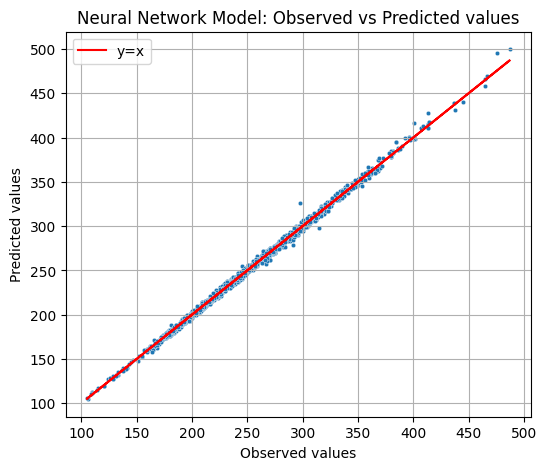

In [46]:
# Test the model on the test dataset------------------------   
# Using MSE as the evaluation metrics: Mean Squared Error, R2, MAE, MAPE
nn_model.eval()

# Get the prediction and true values
nn_test_true = []
nn_test_pred = []

val_loss = 0
with torch.no_grad():
    for X_batch, y_batch in test_Loader:

        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        y_pred = nn_model(X_batch)
        loss = criterion(y_pred, y_batch)
        val_loss += loss.item()

        nn_test_true.append(y_batch.cpu().detach().numpy())     # true value
        nn_test_pred.append(y_pred.cpu().detach().numpy())      # predicted value

# concatenate the true and predicted values
nn_test_true = np.concatenate(nn_test_true, axis=0).flatten()
nn_test_pred = np.concatenate(nn_test_pred, axis=0).flatten()

nn_test_r2 = r2_score(nn_test_pred, nn_test_true)
nn_test_mse = mean_squared_error(nn_test_pred, nn_test_true)
nn_test_mae = mean_absolute_error(nn_test_pred, nn_test_true)
nn_test_mape = mean_absolute_percentage_error(nn_test_pred, nn_test_true)

# Output
print(f'Neural Network Model:')
print(f"    Test Dataset MSE: {nn_test_mse:.4f}")
print(f"    Test Dataset R2: {nn_test_r2:.4f}")
print(f"    Test Dataset MAE: {nn_test_mae:.4f}")
print(f"    Test Dataset MAPE: {nn_test_mape:.4f}")

# Using plot
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
plot_pred_true(nn_test_true, nn_test_pred, ax)
plt.title('Neural Network Model: Observed vs Predicted values')

In [47]:
print(f"Test Dataset MSE: {nn_test_mse:.4f}")
print(f"Validation Dataset MSE: {np.mean(nn_k_fold_mse):.4f}")

Test Dataset MSE: 8.5545
Validation Dataset MSE: 8.2751


### 3.1.6 Save the NN Model Performance

Output of Best NN Model

- Output will include two types of data: Validation values, and Test Values, and combine those into one dataframe.

- Validation RSE:  1 x 20    Test RSE: 1 x 1

- Validation R2:   1 x 20    Test R2:  1 x 1

- Validation MAE:  1 x 20    Test MAE:  1 x 1

- Validation MAPE: 1 x 20    Test MAPE:  1 x 1

- So the output dataframe should include:

    - **4 rows**: RSE, R2, MAE and MAPE 
    
    - **21 cols**:  first 20 as validation metrics, with the last one being test metric

In [48]:
# Save the output of Best NN Model 
nn_metrics = pd.DataFrame([nn_k_fold_mse, nn_k_fold_R2, nn_k_fold_mae, nn_k_fold_mape])

# Add Test results
nn_metrics["Test_results"] = [nn_test_mse, nn_test_r2, nn_test_mae, nn_test_mape]


In [49]:
nn_metrics.columns = [f"fold_{i+1}" for i in range(20)] + ["Test"]
nn_metrics.index = ['MSE', 'R2', 'MAE', 'MAPE']


In [50]:
nn_metrics

,fold_1,fold_2,fold_3,fold_4,fold_5,fold_6,fold_7,fold_8,fold_9,fold_10,...,fold_12,fold_13,fold_14,fold_15,fold_16,fold_17,fold_18,fold_19,fold_20,Test
MSE,6.282833,7.078762,8.355918,6.796704,8.243905,7.840073,7.375906,8.806746,7.416917,21.331717,...,6.625337,7.370185,7.105981,7.790254,6.510433,8.161133,7.478849,7.495782,6.508544,8.554526
R2,0.998102,0.998123,0.997939,0.998074,0.997400,0.997848,0.997886,0.997082,0.997845,0.993955,...,0.998090,0.997730,0.997406,0.997716,0.998079,0.997508,0.997841,0.997522,0.998192,0.997559
MAE,1.985755,2.111047,2.231801,2.073358,2.268949,2.162261,2.035594,2.266077,2.096266,2.210760,...,2.118980,2.053485,2.124481,2.275039,2.107371,2.133236,2.213015,2.090110,2.003258,2.208800
MAPE,0.008174,0.008431,0.008757,0.008228,0.009224,0.008652,0.008264,0.009074,0.008618,0.010023,...,0.008541,0.008550,0.008683,0.008957,0.008432,0.008624,0.008711,0.008353,0.007992,0.008913


In [51]:
nn_test_pred_df = pd.DataFrame(nn_test_pred, columns=["y"])
nn_test_pred_df.to_csv("Workstream_1_ML_models/nn_test_pred.csv", index=False)  

In [52]:
nn_metrics.to_csv("Best_NN_Model_performance.csv", index=True)